In [16]:
"""
Calculate fire severity statistics within AFD observations from MODIS and VIIRS.
Severity index: Composite Burn Severity (CBI), calculated in GEE via Parks (2018)

Author: maxwell.cook@colorado.edu
"""

import ee
import geemap

import os, time
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # suppresses annoying geopandas warning

ee.Authenticate()

ee.Initialize(project='jfsp-aspen')

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Success")

Success


In [2]:
def monitor_export(task, sleep=30):
    """ Monitors EE export task """
    while task.active():
        print('Waiting for export to finish..\n\tPatience young padawan.')
        time.sleep(sleep)  # Check every 30 seconds
    
    # Get the status of the task
    status = task.status()
    
    # Check if the task failed or succeeded
    if status['state'] == 'COMPLETED':
        print("Export completed successfully !!!!")
    elif status['state'] == 'FAILED':
        print(f"Export failed! Bummer. Reason: {status.get('error_message', 'Unknown error')}")
    else:
        print(f"Export ended with state: {status['state']}")

print("Functions ready!")

Functions ready!


In [3]:
# Load the FRP observations
afd = ee.FeatureCollection('projects/jfsp-aspen/assets/AFD/combined-afd_aspen-fires_2018_to_2023')
print(afd.first().propertyNames().getInfo())

['fid', 'FRP', 'NIFC_NAME', 'LONGITUDE', 'ACQ_YEAR', 'ACQ_TIME', 'SCAN', 'BRIGHTNESS', 'CONFIDENCE', 'TYPE', 'SATELLITE', 'na_l3name', 'DAYNIGHT', 'TRACK', 'INSTRUMENT', 'VID', 'NIFC_ID', 'START_YEAR', 'ACQ_DATETI', 'ACQ_MONTH', 'WF_CESSATI', 'VERSION', 'BRIGHT_T31', 'DISCOVERY_', 'afdID', 'LATITUDE', 'system:index', 'ACQ_DATE']


In [4]:
afd = afd.select(['afdID'])
print(afd.first().propertyNames().getInfo())

['system:index', 'afdID']


In [5]:
# Load the CBI mosaic
cbi = ee.Image('projects/jfsp-aspen/assets/CBI/afd_aspen-fires_cbi_mosaic')
print(cbi.bandNames().getInfo())

['CBI', 'CBI_bc', 'rbr']


In [6]:
# Set up the reductions for CBI statistics in AFD observations and export.

In [8]:
# Multiple reducer
mean_med_stdDev = ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(), sharedInputs=True).combine(
    reducer2=ee.Reducer.median(), sharedInputs=True)

# Perform the reduction by AFD observations
cbi_stats = cbi.reduceRegions(
    collection=afd,
    reducer=mean_med_stdDev, # Mean and Standard Deviation CBI, CBI_bc, rbr
    scale=30
)

print("Submitted !")

Submitted !


In [9]:
# Export table to Drive.

cbi_stats = cbi_stats.map(lambda feature: feature.setGeometry(None)) # drop geometry column

export_task = ee.batch.Export.table.toDrive(
    collection=cbi_stats,
    description='afd_aspen-fires_cbi-stats',
    fileFormat='CSV', 
    fileNamePrefix='afd_aspen-fires_cbi-stats',
    folder='CBI'
)

# Start the export task
export_task.start()
print("Export to Earth Engine Asset started!")
# Monitor the task until it's finished
monitor_export(export_task, 120) # print every 2 min

Export to Earth Engine Asset started!
Waiting for export to finish..
	Patience young padawan.
Waiting for export to finish..
	Patience young padawan.
Waiting for export to finish..
	Patience young padawan.
Export completed successfully !!!!


In [ ]:
# Work with the exported data.

In [10]:
# Load the exported table.
fp = os.path.join(projdir,'data/earth-engine/exports/cbi/afd_aspen-fires_cbi-stats.csv')
cbi = pd.read_csv(fp)
cbi.columns

Index(['system:index', 'CBI_bc_mean', 'CBI_bc_median', 'CBI_bc_stdDev',
       'CBI_mean', 'CBI_median', 'CBI_stdDev', 'afdID', 'rbr_mean',
       'rbr_median', 'rbr_stdDev', '.geo'],
      dtype='object')

In [11]:
cbi.drop(columns=['system:index','.geo'], inplace=True)
cbi.head()

,CBI_bc_mean,CBI_bc_median,CBI_bc_stdDev,CBI_mean,CBI_median,CBI_stdDev,afdID,rbr_mean,rbr_median,rbr_stdDev
0,1.345921,1.16581,0.766035,1.405602,1.254632,0.621546,MODIS12004,176.382395,124.973379,135.908069
1,0.639773,0.12000,0.921366,0.811641,0.445554,0.770013,MODIS12037,87.950558,25.545880,136.633111
2,2.357810,2.69000,0.702763,2.240195,2.524546,0.587089,MODIS12038,385.084445,425.293223,169.026412
3,1.987865,2.21000,0.773277,1.931922,2.113200,0.633484,MODIS12039,293.339556,301.692308,145.768924
4,1.765142,1.74000,0.872010,1.751206,1.710000,0.715643,MODIS12040,246.728583,206.400000,156.294200


In [ ]:
# Join back to the afd data.

In [13]:
fp = os.path.join(projdir,'data/spatial/mod/AFD/combined-afd_aspen-fires_2018_to_2023_buffer.gpkg')
afd = gpd.read_file(fp)
afd.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'VID', 'NIFC_ID', 'NIFC_NAME',
       'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'na_l3name',
       'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME', 'afdID', 'geometry'],
      dtype='object')

In [34]:
# Merge to AFDs
cbi_ = cbi[['afdID','CBI_bc_median']] # keep just the mean CBI (bias corrected)
afd_ = pd.merge(afd, cbi_, right_on='afdID', left_on='afdID', how='left')

# Tidy the columns for comparison of FRP and CBI.
afd_cbi = afd_[['afdID','NIFC_ID','NIFC_NAME','START_YEAR','DISCOVERY_DATE','WF_CESSATION_DATE',
                'SATELLITE','INSTRUMENT','ACQ_MONTH','ACQ_YEAR','ACQ_DATETIME','DAYNIGHT',
                'FRP','CBI_bc_median','na_l3name','LATITUDE','LONGITUDE']]
afd_cbi.head()

,afdID,NIFC_ID,NIFC_NAME,START_YEAR,DISCOVERY_DATE,WF_CESSATION_DATE,SATELLITE,INSTRUMENT,ACQ_MONTH,ACQ_YEAR,ACQ_DATETIME,DAYNIGHT,FRP,CBI_bc_median,na_l3name,LATITUDE,LONGITUDE
0,MODIS7298,9582,SAULS,2018,2018-05-15 21:06:00,2018-06-16 19:00:00,Aqua,MODIS,5,2018,2018-05-17 20:36:00+00:00,D,9.4,0.254734,Wasatch and Uinta Mountains,39.4852,-111.7325
1,MODIS7301,9582,SAULS,2018,2018-05-15 21:06:00,2018-06-16 19:00:00,Aqua,MODIS,5,2018,2018-05-17 20:36:00+00:00,D,72.8,0.056974,Wasatch and Uinta Mountains,39.4836,-111.7439
2,MODIS7989,69318,PINE RIDGE,2018,2018-05-26 14:03:00,2018-05-27 18:30:00,Aqua,MODIS,5,2018,2018-05-26 20:30:00+00:00,D,232.9,0.226051,Colorado Plateaus,40.5781,-109.7424
3,MODIS7990,69318,PINE RIDGE,2018,2018-05-26 14:03:00,2018-05-27 18:30:00,Aqua,MODIS,5,2018,2018-05-26 20:30:00+00:00,D,66.5,0.180000,Colorado Plateaus,40.5797,-109.7306
4,MODIS7991,69318,PINE RIDGE,2018,2018-05-26 14:03:00,2018-05-27 18:30:00,Aqua,MODIS,5,2018,2018-05-26 20:30:00+00:00,D,93.1,0.000000,Colorado Plateaus,40.5692,-109.7402


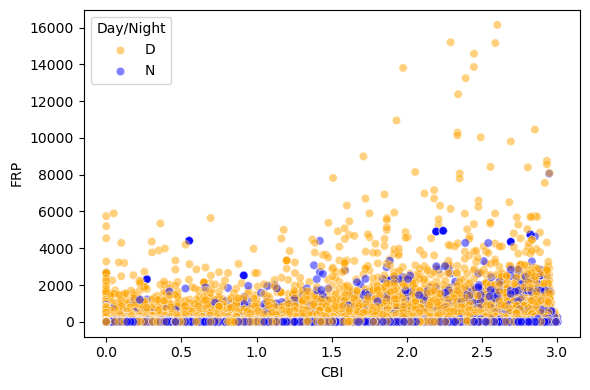

In [35]:
plt.figure(figsize=(6, 4))

sns.scatterplot(
    x='CBI_bc_median', y='FRP', 
    data=afd_cbi, 
    hue='DAYNIGHT', 
    alpha=0.5, 
    palette={'D': 'orange', 'N': 'blue'})

plt.xlabel('CBI')
plt.ylabel('FRP')
plt.legend(title='Day/Night')
plt.tight_layout()
plt.show()

In [36]:
from scipy.stats import pearsonr

day_data = afd_cbi[afd_cbi['DAYNIGHT'] == 'D']
night_data = afd_cbi[afd_cbi['DAYNIGHT'] == 'N']

# Correlation for day
corr_day, p_value_day = pearsonr(day_data['FRP'], day_data['CBI_bc_median'])
print(f'Day: Pearson correlation = {corr_day:.3f}, p-value = {p_value_day}')

# Correlation for night
corr_night, p_value_night = pearsonr(night_data['FRP'], night_data['CBI_bc_median'])
print(f'Night: Pearson correlation = {corr_night:.3f}, p-value = {p_value_night}')

Day: Pearson correlation = 0.108, p-value = 4.0404639253926874e-174
Night: Pearson correlation = 0.062, p-value = 1.7950841907705585e-77


In [ ]:
# Export table

In [39]:
out_fp = os.path.join(projdir,'data/tabular/mod/AFD/combined-afd_aspen-fires_cbi.csv')
afd_cbi.to_csv(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/AFD/combined-afd_aspen-fires_cbi.csv
